In [21]:
import gym
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)

[2017-08-22 02:11:18,413] Making new env: CartPole-v0


Discrete(2)
Box(4,)


In [22]:
print(env.observation_space.high)
print(env.observation_space.low)

[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


In [77]:
class Agent():
    def __init__(self, epsilon, learning_rate):
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.sess = tf.InteractiveSession()
        self.s = tf.placeholder(tf.float32, [None, 4], name='s')
        self.a = tf.placeholder(tf.int32, [None], name='a')
        self.r = tf.placeholder(tf.float32, [None], name='r')
         
        self.W1 = tf.Variable(tf.zeros([4, 10]), name='W1')
        self.b1 = tf.Variable(tf.zeros([10]), name='b1')
        self.hidden = tf.nn.softmax(tf.matmul(self.s, self.W1) + self.b1)
        self.W2 = tf.Variable(tf.zeros([10, 2]), name='W2')
        self.b2 = tf.Variable(tf.zeros([2]), name='b2')
        self.output = tf.nn.softmax(tf.matmul(self.hidden, self.W2) + self.b2)
        one_hot = tf.one_hot(self.a, 2)
        o = tf.reduce_sum(self.output * one_hot, axis=1)
        loss = -tf.reduce_sum(tf.log(o) * self.r)
        
        W1g, b1g, W2g, b2g = tf.gradients(loss, [self.W1, self.b1, self.W2, self.b2])
        solver = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.update = solver.apply_gradients([(W1g, self.W1), (b1g, self.b1), (W2g, self.W2), (b2g, self.b2)])
        
    def train(self, s, a, r):
        self.sess.run(self.update, {self.s: s, self.a: a, self.r: r})
        
    def decide(self, s):
        o = self.sess.run(self.output, {self.s: [s]})[0]
        return 0 if np.random.random() <= o[0] else 1

In [78]:
gamma = 0.95
n_episodes = 10000
train_every = 5
tf.reset_default_graph()
agent = Agent(epsilon=0.05, learning_rate=0.1)
tf.global_variables_initializer().run()
s_all, a_all, r_all = [], [], []
nits = []
for ei in range(n_episodes):
    s_arr, a_arr, r_arr = [], [], []
    s = env.reset()
    nit = 0
    done = False
    while not done:
        a = agent.decide(s)
        s1, r, done, _ = env.step(a)
        nit += 1
        s_arr.append(s)
        a_arr.append(int(a))
        r_arr.append(r)
        s = s1
    nits.append(nit)
    if ei % 100 == 0:
        print("Episode {} ran for {} steps".format(ei, nit))
    for i in reversed(range(nit)):
        if i + 1 < nit:
            r_arr[i] += gamma * r_arr[i+1]
    nit = 0
    
    s_all += s_arr
    a_all += a_arr
    r_all += r_arr
    s_arr, a_arr, r_arr = [], [], []
    if ei > 0 and ei % train_every == 0:        
        r_all_np = np.array(r_all)
        r_all_np = (r_all_np - np.mean(r_all_np)) / np.std(r_all_np)
        agent.train(s_all, a_all, r_all_np)
        s_all, a_all, r_all = [], [], []

Episode 0 ran for 24 steps
Episode 100 ran for 11 steps
Episode 200 ran for 39 steps
Episode 300 ran for 20 steps
Episode 400 ran for 14 steps
Episode 500 ran for 14 steps
Episode 600 ran for 27 steps
Episode 700 ran for 43 steps
Episode 800 ran for 17 steps
Episode 900 ran for 17 steps
Episode 1000 ran for 14 steps
Episode 1100 ran for 17 steps
Episode 1200 ran for 99 steps
Episode 1300 ran for 125 steps
Episode 1400 ran for 198 steps
Episode 1500 ran for 116 steps
Episode 1600 ran for 132 steps
Episode 1700 ran for 134 steps
Episode 1800 ran for 119 steps
Episode 1900 ran for 86 steps
Episode 2000 ran for 133 steps
Episode 2100 ran for 200 steps
Episode 2200 ran for 200 steps
Episode 2300 ran for 200 steps
Episode 2400 ran for 177 steps
Episode 2500 ran for 200 steps
Episode 2600 ran for 188 steps


KeyboardInterrupt: 

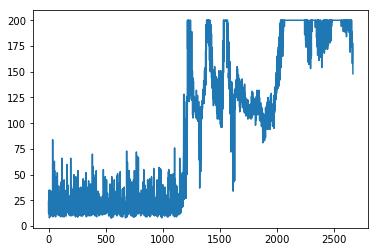

In [79]:
plt.plot(nits)

In [12]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

from gym import wrappers


def discounted_reward(rewards, gamma):
    """Compute the discounted reward."""
    ans = np.zeros_like(rewards)
    running_sum = 0
    # compute the result backward
    for i in reversed(range(len(rewards))):
        running_sum = running_sum * gamma + rewards[i]
        ans[i] = running_sum
    return ans


def test():
    """Just a test function to make sure I'm coding the
    right thing. """
    rewards = np.array([4, 2, 2, 1])
    print(discounted_reward(rewards, 1))
    # print out some help information about the environment
    env = gym.make('CartPole-v0')
    s = env.reset()
    print('Start state: ', s)
    print('Action space: ', env.action_space.n)


class Agent(object):
    def __init__(self, input_size=4, hidden_size=2, gamma=0.95,
                 action_size=2, alpha=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.action_size = action_size
        self.alpha = alpha
        # save the hyper parameters
        self.params = self.__dict__.copy()
        # placeholders
        self.input_pl = tf.placeholder(tf.float32, [None, input_size])
        self.action_pl = tf.placeholder(tf.int32, [None])
        self.reward_pl = tf.placeholder(tf.float32, [None])
        # a two-layer fully connected network
        hidden_layer = layers.fully_connected(self.input_pl,
                                              hidden_size,
                                              biases_initializer=None,
                                              activation_fn=tf.nn.relu)
        self.output = layers.fully_connected(hidden_layer,
                                             action_size,
                                             biases_initializer=None,
                                             activation_fn=tf.nn.softmax)
        # responsible output
        one_hot = tf.one_hot(self.action_pl, action_size)
        responsible_output = tf.reduce_sum(self.output * one_hot, axis=1)
        self.loss = -tf.reduce_mean(tf.log(responsible_output) * self.reward_pl)
        # training variables
        variables = tf.trainable_variables()
        self.variable_pls = []
        for i, var in enumerate(variables):
            self.variable_pls.append(tf.placeholder(tf.float32))
        self.gradients = tf.gradients(self.loss, variables)
        solver = tf.train.AdamOptimizer(learning_rate=alpha)
        self.update = solver.apply_gradients(zip(self.variable_pls, variables))

    def next_action(self, sess, feed_dict, greedy=False):
        """Pick an action based on the current state.
        Args:
        - sess: a tensorflow session
        - feed_dict: parameter for sess.run()
        - greedy: boolean, whether to take action greedily
        Return:
            Integer, action to be taken.
        """
        ans = sess.run(self.output, feed_dict=feed_dict)[0]
        if greedy:
            return ans.argmax()
        else:
            return np.random.choice(range(self.action_size), p=ans)

    def show_parameters(self):
        """Helper function to show the hyper parameters."""
        for key, value in self.params.items():
            print(key, '=', value)


render = False
update_every = 3
print_every = 50
n_episodes = 5
rate = 0.01
running_reward = 0.0
tf.reset_default_graph()
agent = Agent(hidden_size=10, alpha=1e-1, gamma=0.95)
agent.show_parameters()
env = gym.make('CartPole-v0')
#env = wrappers.Monitor(env, 'tmp/trial/', force=True)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    grad_buffer = sess.run(tf.trainable_variables())
    for idx in range(len(grad_buffer)):
        grad_buffer[idx] *= 0
    for i in range(n_episodes):
        s = env.reset()
        state_history = []
        reward_history = []
        action_history = []
        current_reward = 0
        while True:
            feed_dict = {agent.input_pl: [s]}
            greedy = False
            action = agent.next_action(sess, feed_dict, greedy=greedy)
            snext, r, done, _ = env.step(action)
            if render and i % 50 == 0:
                env.render()
            current_reward += r
            state_history.append(s)
            reward_history.append(r)
            action_history.append(action)
            s = snext
            if done:
                state_history = np.array(state_history)
                rewards = discounted_reward(reward_history, agent.gamma)
                R = rewards
                # normalizing the reward really helps
                rewards = (rewards - np.mean(rewards)) / np.std(rewards)
                feed_dict = {
                    agent.reward_pl: rewards,
                    agent.action_pl: action_history,
                    agent.input_pl: state_history
                }
                episode_gradients = sess.run(agent.gradients,
                                             feed_dict=feed_dict)
                print("updating ep gradient")
                for idx, grad in enumerate(episode_gradients):
                    grad_buffer[idx] += grad

                if i % update_every == 0:
                    print('updating')
                    feed_dict = dict(zip(agent.variable_pls, grad_buffer))
                    sess.run(agent.update, feed_dict=feed_dict)
                    # reset the buffer to zero
                    for idx in range(len(grad_buffer)):
                        grad_buffer[idx] *= 0
                if i % print_every == 0:
                    print('episode %d, current_reward %d, running_reward %d' % (i, current_reward, running_reward))
                break
        running_reward = rate * current_reward + (1 - rate) * running_reward


#if __name__ == '__main__':
#    test()
#train()

[2017-08-20 15:38:18,488] Making new env: CartPole-v0


input_size = 4
hidden_size = 10
gamma = 0.95
action_size = 2
alpha = 0.1
updating ep gradient
updating
episode 0, current_reward 12, running_reward 0
updating ep gradient
updating ep gradient
updating ep gradient
updating
updating ep gradient
